# 1) Importing Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import warnings
warnings.filterwarnings("ignore")

# 2) Loading The Dataset

In [2]:
cursor = sqlite3.connect(r'../../database/laptrack.db')

laptop_df = pd.read_sql_query("SELECT * FROM Laptop_Phase_2_2", cursor)

cursor.close()

laptop_df.head()

,Brand,Laptop_Model_Name,Laptop_Model_Number,Processor_Brand,Processor_Model,Storage_Type,Operating_System,Display_Resolution,Extracted_Rating,Battery_Life(Hours_Upto),...,Stock,Time_Of_Extraction,URL,Source,Storage_Capacity(GB),Display_Size(Inches),RAM(GB),No_Of_Reviews,Laptop_Dimensions,Laptop_Weight(Pounds)
0,Dell,Latitude 3540 Laptop,None,Intel,1355U,SSD,Windows 11 Professional,1920x1080 MP,NaN,NaN,...,1,2024-11-04 18:23:39,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4000,15.6,64,0,0.71 x 14.13 x 9.44 inches,4.00
1,HP,17t-cn3004,17t-cn3004208,Intel,Intel Core i5,SSD,Windows 11 Pro,1600x900 Pixels,5.0,NaN,...,1,2024-11-04 18:23:42,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4096,17.3,64,0,0.81 x 10.15 x 15.78 inches,5.00
2,Dell,"Dell Inspiron 15.6"" Touchscreen Laptop",None,Intel,1355U,SSD,Windows 11 Pro,1920x1080 Pixels,NaN,NaN,...,1,2024-11-04 18:23:45,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,Amazon,4096,15.6,32,0,9.25 x 0.75 x 14.11 inches,3.60
3,Apple,MacBook Pro,Mvvm2ll/a,Intel,Core i9,SSD,Mac OS X 10.0 Cheetah,2560 x 1600 Pixels,4.0,11.0,...,1,2024-11-04 18:23:54,https://www.amazon.com/2019-Apple-MacBook-16-i...,Amazon,2048,16.0,16,0,15.63 x 2.40 x 11.14 inches,5.68
4,HP,TPN-Q279,TPN-Q279,AMD,Ryzen 5,SSD,Windows 11 Home,1920 x 1080 Pixels,3.8,NaN,...,1,2024-11-04 18:23:57,https://www.amazon.com/HP-i7-1355U-i5-14400F-G...,Amazon,2048,15.6,16,0,0.93 x 10.04 x 14.09 inches,7.39


# 3) Preparing Data for Model Building


Top Features Correlated with Price:
Display_Resolution_Height: 0.539
Display_Resolution_Width: 0.533
Storage_Capacity(GB): 0.444
RAM(GB): 0.361
Display_Size(Inches): 0.288
Processor_Model: 0.082
Extracted_Rating: 0.078
Battery_Life(Hours_Upto): 0.060
Processor_Brand: 0.024
Laptop_Weight(Pounds): -0.001
No_Of_Reviews: -0.008
Brand: -0.027
Storage_Type: -0.088


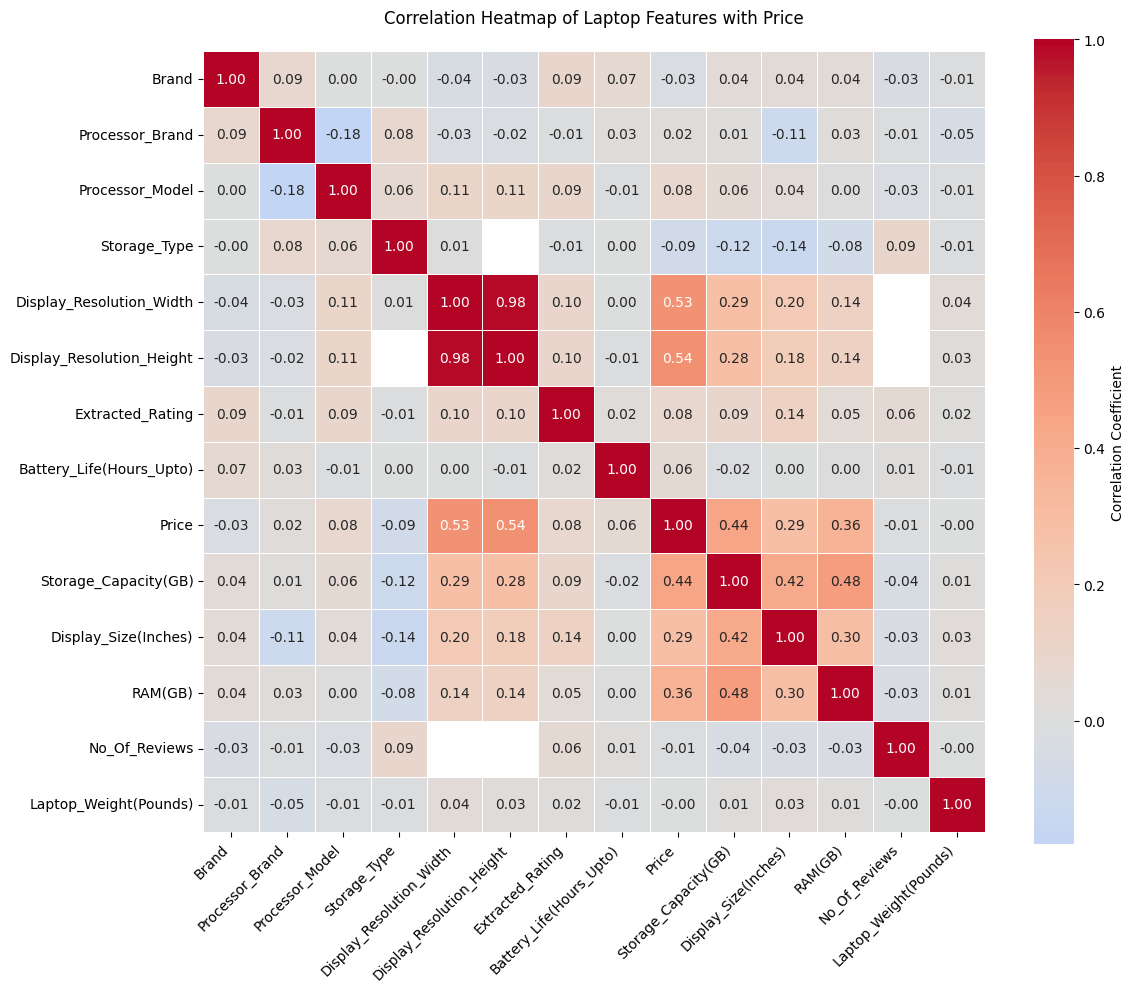

In [3]:
def create_correlation_heatmap(df):
    # Create a copy of the DataFrame
    df_corr = df.copy()
    
    # Convert categorical variables to numeric
    categorical_columns = ['Brand', 'Processor_Brand', 'Processor_Model', 
                         'Storage_Type', 'Operating_System']
    
    for col in categorical_columns:
        df_corr[col] = pd.Categorical(df_corr[col]).codes
    
    # Extract numeric values from Display_Resolution
    df_corr['Display_Resolution_Width'] = df_corr['Display_Resolution'].str.extract('(\d+)x').astype(float)
    df_corr['Display_Resolution_Height'] = df_corr['Display_Resolution'].str.extract('x(\d+)').astype(float)
    
    # Select numerical columns for correlation
    numerical_columns = [
        'Brand', 'Processor_Brand', 'Processor_Model', 'Storage_Type',
        'Display_Resolution_Width', 'Display_Resolution_Height',
        'Extracted_Rating', 'Battery_Life(Hours_Upto)',
        'Price', 'Storage_Capacity(GB)', 'Display_Size(Inches)',
        'RAM(GB)', 'No_Of_Reviews', 'Laptop_Weight(Pounds)'
    ]
    
    # Calculate correlation matrix
    correlation_matrix = df_corr[numerical_columns].corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, 
                annot=True,  # Show correlation values
                cmap='coolwarm',  # Color scheme
                center=0,  # Center the colormap at 0
                fmt='.2f',  # Format correlation values to 2 decimal places
                square=True,  # Make cells square
                linewidths=0.5,  # Add gridlines
                cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title('Correlation Heatmap of Laptop Features with Price', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return correlation_matrix

# Function to print top correlations with price
def print_price_correlations(correlation_matrix):
    # Get correlations with price
    price_correlations = correlation_matrix['Price'].sort_values(ascending=False)
    
    print("\nTop Features Correlated with Price:")
    print("===================================")
    # Print all correlations except price with itself
    for feature, correlation in price_correlations.items():
        if feature != 'Price':
            print(f"{feature}: {correlation:.3f}")


correlation_matrix = create_correlation_heatmap(laptop_df)
print_price_correlations(correlation_matrix)

In [4]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, 
                                ElasticNet, HuberRegressor, TheilSenRegressor, RANSACRegressor)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
def preprocess_data(df):
    """Preprocess the laptop data with appropriate handling of categorical and numerical features"""
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Extract resolution values
    df_processed['Display_Resolution_Width'] = df_processed['Display_Resolution'].str.extract('(\d+)x').astype(float)
    df_processed['Display_Resolution_Height'] = df_processed['Display_Resolution'].str.extract('x(\d+)').astype(float)
    
    # Select features
    numerical_features = [
        'Display_Resolution_Height', 'Display_Resolution_Width',
        'Storage_Capacity(GB)', 'RAM(GB)', 'Display_Size(Inches)',
        'Extracted_Rating', 'Battery_Life(Hours_Upto)', 'No_Of_Reviews',
        'Laptop_Weight(Pounds)'
    ]
    
    categorical_features = [
        'Processor_Model', 'Brand', 'Storage_Type',
        'Operating_System'
    ]
    
    # Handle missing values in numerical features
    for col in numerical_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # Handle missing values in categorical features
    for col in categorical_features:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])
    
    # Create feature dataframe
    X = pd.DataFrame()
    
    # Scale numerical features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df_processed[numerical_features])
    X = pd.DataFrame(X_scaled, columns=numerical_features)
    
    # Encode categorical features
    for col in categorical_features:
        le = LabelEncoder()
        encoded_feature = le.fit_transform(df_processed[col])
        X[col] = encoded_feature
    
    # Get target variable
    y = df_processed['Price']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(y_true, y_pred, n_features):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Adjusted_R2': adj_r2
    }

In [7]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate all regression models"""
    models = [
        ('KNN', KNeighborsRegressor(n_neighbors=5)),
        ('Decision Tree', DecisionTreeRegressor(random_state=42)),
        ('Linear Regression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0, random_state=42)),
        ('Lasso', Lasso(alpha=1.0, random_state=42)),
        ('Elastic Net', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)),
        ('SVR', SVR(kernel='rbf', C=1.0, epsilon=0.1)),
        ('Huber', HuberRegressor(epsilon=1.35)),
        ('Theil-Sen', TheilSenRegressor(random_state=42)),
        ('RANSAC', RANSACRegressor(random_state=42)),
        ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('GBDT', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('XGBoost', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ]
    
    results = {}
    n_features = X_train.shape[1]
    
    for name, model in models:
        print(f"Training {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        metrics = evaluate_model(y_test, y_pred, n_features)
        results[name] = metrics
        
        # Print interim results
        print(f"{name} Results:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print("-" * 50)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    
    return results_df

In [8]:
def main(df):
    """Main execution function"""
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(df)
    
    # Train and evaluate models
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    # Display final results
    print("\nFinal Results:")
    print(results.round(4))
    
    # Sort models by R2 score
    print("\nModels ranked by R2 score:")
    print(results.sort_values('R2', ascending=False)['R2'].round(4))
    
    return results, X_train, X_test, y_train, y_test

In [9]:
results, X_train, X_test, y_train, y_test = main(laptop_df)
print(results.sort_values('R2', ascending=False))

Training KNN...
KNN Results:
MSE: 231037.4966
RMSE: 480.6636
R2: 0.4490
Adjusted_R2: 0.4403
--------------------------------------------------
Training Decision Tree...
Decision Tree Results:
MSE: 253905.7381
RMSE: 503.8906
R2: 0.3945
Adjusted_R2: 0.3849
--------------------------------------------------
Training Linear Regression...
Linear Regression Results:
MSE: 336371.1694
RMSE: 579.9751
R2: 0.1978
Adjusted_R2: 0.1852
--------------------------------------------------
Training Ridge...
Ridge Results:
MSE: 336363.3485
RMSE: 579.9684
R2: 0.1978
Adjusted_R2: 0.1852
--------------------------------------------------
Training Lasso...
Lasso Results:
MSE: 336250.4378
RMSE: 579.8711
R2: 0.1981
Adjusted_R2: 0.1855
--------------------------------------------------
Training Elastic Net...
Elastic Net Results:
MSE: 335035.7975
RMSE: 578.8228
R2: 0.2010
Adjusted_R2: 0.1884
--------------------------------------------------
Training SVR...
SVR Results:
MSE: 457103.4440
RMSE: 676.0943
R2: -0.09

# 4) Performing Hyper Parameter Tuning on the top 3 models

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import joblib
from scipy.stats import randint, uniform
import pickle 
import os

In [11]:
def tune_xgboost(X_train, X_test, y_train, y_test, n_iter=100):
    """Tune XGBoost hyperparameters"""
    print("Tuning XGBoost...")
    param_distributions = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 7),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 5),
        'reg_lambda': uniform(0, 5)
    }
    
    xgb_model = xgb.XGBRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        xgb_model, param_distributions, n_iter=n_iter,
        cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=2
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [12]:
def tune_random_forest(X_train, X_test, y_train, y_test, n_iter=100):
    """Tune Random Forest hyperparameters"""
    print("Tuning Random Forest...")
    param_distributions = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(10, 110),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    
    rf_model = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        rf_model, param_distributions, n_iter=n_iter,
        cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=2
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_


In [13]:
def tune_gbdt(X_train, X_test, y_train, y_test, n_iter=100):
    """Tune Gradient Boosting Decision Trees hyperparameters"""
    print("Tuning GBDT...")
    param_distributions = {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'subsample': uniform(0.6, 0.4),
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    gbdt_model = GradientBoostingRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        gbdt_model, param_distributions, n_iter=n_iter,
        cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=2
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_


In [14]:
def evaluate_tuned_model(model, X_test, y_test):
    """Evaluate the tuned model"""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Adjusted_R2': adj_r2
    }

In [15]:
def main_tuning(X_train, X_test, y_train, y_test, n_iter=100):
    """Main function to tune all models"""
    # Dictionary to store results
    results = {}
    best_models = {}
    best_params = {}
    
    # Tune XGBoost
    xgb_model, xgb_params, xgb_score = tune_xgboost(X_train, X_test, y_train, y_test, n_iter)
    best_models['XGBoost'] = xgb_model
    best_params['XGBoost'] = xgb_params
    results['XGBoost'] = evaluate_tuned_model(xgb_model, X_test, y_test)
    
    # Tune Random Forest
    rf_model, rf_params, rf_score = tune_random_forest(X_train, X_test, y_train, y_test, n_iter)
    best_models['RandomForest'] = rf_model
    best_params['RandomForest'] = rf_params
    results['RandomForest'] = evaluate_tuned_model(rf_model, X_test, y_test)
    
    # Tune GBDT
    gbdt_model, gbdt_params, gbdt_score = tune_gbdt(X_train, X_test, y_train, y_test, n_iter)
    best_models['GBDT'] = gbdt_model
    best_params['GBDT'] = gbdt_params
    results['GBDT'] = evaluate_tuned_model(gbdt_model, X_test, y_test)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).T
    
    return results_df, best_models, best_params

In [16]:
results_df, best_models, best_params = main_tuning(X_train, X_test, y_train, y_test, n_iter=100)

# Print results
print("\nTuned Model Results:")
print(results_df.round(4))
print("\nBest Parameters:")
for model, params in best_params.items():
    print(f"\n{model}:")
    for param, value in params.items():
        print(f"{param}: {value}")

Tuning XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuning Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuning GBDT...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Tuned Model Results:
                      MSE      RMSE      R2  Adjusted_R2
XGBoost       100303.9623  316.7080  0.7608       0.7570
RandomForest  113862.8698  337.4357  0.7285       0.7242
GBDT          101470.4289  318.5442  0.7580       0.7542

Best Parameters:

XGBoost:
colsample_bytree: 0.6072301454462083
gamma: 2.469468575917173
learning_rate: 0.06364681276639864
max_depth: 10
min_child_weight: 3
n_estimators: 500
reg_alpha: 1.540303959261946
reg_lambda: 2.7127011527744966
subsample: 0.803525630735504

RandomForest:
bootstrap: False
max_depth: 44
max_features: log2
min_samples_leaf: 1
min_samples_split: 3
n_estimators: 875

GBDT:
learning_rate: 0.07238249886045664
max_depth: 6
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 3

In [19]:
def save_models_and_preprocessing(best_models, scaler, label_encoders, folder_path='saved_models/'):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Save the best models
    for name, model in best_models.items():
        with open(f'{folder_path}{name}_model.pkl', 'wb') as file:
            pickle.dump(model, file)
    
    # Save the scaler
    with open(f'{folder_path}scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)
        
    # Save the label encoders dictionary
    with open(f'{folder_path}label_encoders.pkl', 'wb') as file:
        pickle.dump(label_encoders, file)

# Create label encoders
categorical_features = ['Processor_Model', 'Brand', 'Storage_Type', 'Operating_System']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    le.fit(laptop_df[col].astype(str))
    label_encoders[col] = le

# Create and fit scaler
scaler = RobustScaler()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler.fit(X_train[numerical_columns])

# Save everything
save_models_and_preprocessing(best_models, scaler, label_encoders)

In [21]:
def load_and_predict(input_data, folder_path='saved_models/'):
    """Load saved models and preprocessing objects and make predictions"""
    import os
    import pickle
    
    # Load models
    models = {}
    model_files = [f for f in os.listdir(folder_path) if f.endswith('_model.pkl')]
    for model_file in model_files:
        model_name = model_file.replace('_model.pkl', '')
        with open(f'{folder_path}{model_file}', 'rb') as file:
            models[model_name] = pickle.load(file)
    
    # Load scaler
    with open(f'{folder_path}scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    
    # Load label encoders
    with open(f'{folder_path}label_encoders.pkl', 'rb') as file:
        label_encoders = pickle.load(file)
    
    # Define expected numerical and categorical features
    numerical_features = [
        'Display_Resolution_Height', 'Display_Resolution_Width',
        'Storage_Capacity(GB)', 'RAM(GB)', 'Display_Size(Inches)',
        'Extracted_Rating', 'Battery_Life(Hours_Upto)', 'No_Of_Reviews',
        'Laptop_Weight(Pounds)'
    ]
    
    categorical_features = [
        'Processor_Model', 'Brand', 'Storage_Type', 'Operating_System'
    ]
    
    # Create DataFrame and ensure all required columns exist
    input_df = pd.DataFrame([input_data])
    
    # Add missing numerical columns with 0 or appropriate default value
    for col in numerical_features:
        if col not in input_df.columns:
            input_df[col] = 0  # or some other appropriate default value
    
    # Transform categorical features
    for col in categorical_features:
        if col in input_df.columns:
            input_df[col] = label_encoders[col].transform(input_df[col].astype(str))
        else:
            # Handle missing categorical columns
            input_df[col] = label_encoders[col].transform([label_encoders[col].classes_[0]])
    
    # Ensure columns are in the correct order for the scaler
    input_df = input_df[numerical_features + categorical_features]
    
    # Scale numerical features
    input_df[numerical_features] = scaler.transform(input_df[numerical_features])
    
    # Make predictions with all models
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(input_df)[0]
    
    return predictions

# Example usage:
input_data = {
    'Display_Resolution_Height': 1080,
    'Display_Resolution_Width': 1920,
    'Storage_Capacity(GB)': 512,
    'RAM(GB)': 16,
    'Display_Size(Inches)': 15.6,
    'Processor_Model': 'Core i7',
    'Brand': 'Dell',
    'Storage_Type': 'SSD',
    'Operating_System': 'Windows 11 Pro',
    'Laptop_Weight(Pounds)': 4.5,
    'Extracted_Rating': 4.5,
    'No_Of_Reviews': 100,
    'Battery_Life(Hours_Upto)': 8  
}

predictions = load_and_predict(input_data)
print("\nPredicted Prices:")
for model, price in predictions.items():
    print(f"{model}: ${price:.2f}")


Predicted Prices:
GBDT: $4503.72
RandomForest: $3569.44
XGBoost: $2405.94
